# Traffic Accidents by Each Police Precinct District in Davidson County

In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

#### For region, I'm using Davidson County Police Precinct District Outlines. Let's import and check the first five rows.
- Source: https://data.nashville.gov/Police/Police-Precinct-District-Outlines-GIS-/hknv-udny

In [2]:
policedistricts = gpd.read_file('../data/policeprecinctdistricts.geojson')
print(policedistricts.crs)
policedistricts.head( )

epsg:4326


,precinct,shape_area,shape_len,geometry
0,CENTRAL,98541971.0257,46234.6717307,"MULTIPOLYGON (((-86.77525 36.14894, -86.77649 ..."
1,EAST,562260180.986,90261.1338967,"MULTIPOLYGON (((-86.74977 36.24057, -86.74955 ..."
2,HERMITAGE,2496337143.44,521944.947628,"MULTIPOLYGON (((-86.61306 36.24427, -86.61038 ..."
3,MADISON,1913402934.01,254564.86409,"MULTIPOLYGON (((-86.74955 36.24047, -86.74977 ..."
4,MIDTOWN-HILLS,1317030605.73,187104.273068,"MULTIPOLYGON (((-86.77935 36.14855, -86.77912 ..."


In [3]:
# Check that it's a geodataframe:

type(policedistricts)

geopandas.geodataframe.GeoDataFrame

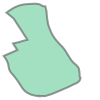

In [6]:
# Check the geometry of the first police district in the region:

policedistricts.loc[0, 'geometry']

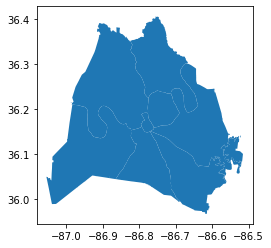

In [7]:
# Plot the geodataframe of the region:

policedistricts.plot();

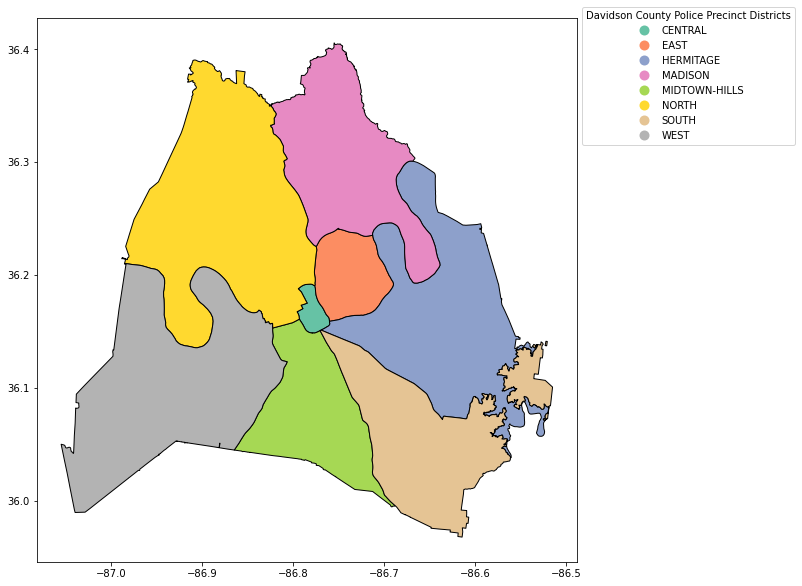

In [10]:
# Jazz up the region with colors denoting each police precinct district along with a legend:

leg_kwds = {'title': 'Davidson County Police Precinct Districts', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 1}

policedistricts.plot(column = 'precinct', figsize=(10, 10),
              edgecolor = 'black',
              legend = True, legend_kwds = leg_kwds, 
              cmap = 'Set2')
plt.show()

#### For points, I'm using Traffic Accidents.
- Source: https://data.nashville.gov/Police/Traffic-Accidents/6v6w-hpcw

In [12]:
# Removed unwanted columns from Traffic_Accidents.csv:

traffic_accidents = pd.read_csv('../data/Traffic_Accidents_cleaned.csv')
print(traffic_accidents.shape)
traffic_accidents.head(3)

(214914, 12)


,Accident Number,Date and Time,Number of Motor Vehicles,Collision Type Description,Weather Description,Street Address,City,ZIP,Precinct,Latitude,Longitude,Mapped Location
0,20200606233,9/21/2020 18:37,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,LEWIS ST & FAIN ST,NASHVILLE,37210.0,HERMIT,36.1518,-86.7580,POINT (-86.758 36.1518)
1,20200603908,9/20/2020 0:00,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,RICHMOND HILL DR & CARTERWOOD DR,NASHVILLE,37207.0,MADISO,36.2323,-86.7733,POINT (-86.7733 36.2323)
2,20200604395,9/20/2020 19:20,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,NaN,SHUTE LN & SAUNDERSVILLE RD,OLD HICKORY,37138.0,HERMIT,36.2267,-86.6032,POINT (-86.6032 36.2267)


In [14]:
# Create a geometry column with POINT datatype out of traffic accidents:

traffic_accidents['geometry'] = traffic_accidents.apply(lambda x: Point((x.Longitude, 
                                                         x.Latitude)), 
                                        axis=1)
traffic_accidents.head(3)

,Accident Number,Date and Time,Number of Motor Vehicles,Collision Type Description,Weather Description,Street Address,City,ZIP,Precinct,Latitude,Longitude,Mapped Location,geometry
0,20200606233,9/21/2020 18:37,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,LEWIS ST & FAIN ST,NASHVILLE,37210.0,HERMIT,36.1518,-86.7580,POINT (-86.758 36.1518),POINT (-86.758 36.1518)
1,20200603908,9/20/2020 0:00,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,RICHMOND HILL DR & CARTERWOOD DR,NASHVILLE,37207.0,MADISO,36.2323,-86.7733,POINT (-86.7733 36.2323),POINT (-86.77330000000001 36.2323)
2,20200604395,9/20/2020 19:20,1.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,NaN,SHUTE LN & SAUNDERSVILLE RD,OLD HICKORY,37138.0,HERMIT,36.2267,-86.6032,POINT (-86.6032 36.2267),POINT (-86.6032 36.2267)


In [ ]:
# Build a geodataframe out of traffic accidents now that it has a geometry column:
